In [172]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2


### load in and normalize the dataset
dataset = np.loadtxt('www.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [173]:
dataset = dataset

In [174]:
dataset = dataset / dataset.max(axis=0)

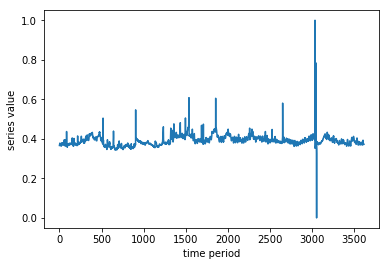

In [175]:
plt.plot(dataset)
plt.xlabel('time period')
plt.ylabel('series value')

In [176]:
def window_transform_series(series, window_size):
    # containers for input/output pairs
    X = []
    y = []
    
    # better algorithm?
    
    # length of series
    series_length = len(series)
    
    for index in range(0, series_length):
        if (series_length-index-window_size)>0:
            X.append(series[index:index+window_size])
            y.append(series[index+window_size])

    # reshape each 
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)

    return X,y

In [177]:
window_size = 7
X,y = window_transform_series(series = dataset,window_size = window_size)

In [178]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point

# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

X_train

array([[[ 0.36634401],
        [ 0.36857781],
        [ 0.37081162],
        ..., 
        [ 0.37751303],
        [ 0.37825763],
        [ 0.37453462]],

       [[ 0.36857781],
        [ 0.37081162],
        [ 0.37453462],
        ..., 
        [ 0.37825763],
        [ 0.37453462],
        [ 0.37453462]],

       [[ 0.37081162],
        [ 0.37453462],
        [ 0.37751303],
        ..., 
        [ 0.37453462],
        [ 0.37453462],
        [ 0.37379002]],

       ..., 
       [[ 0.38421445],
        [ 0.38421445],
        [ 0.38421445],
        ..., 
        [ 0.39240506],
        [ 0.39761727],
        [ 0.40506329]],

       [[ 0.38421445],
        [ 0.38421445],
        [ 0.38719285],
        ..., 
        [ 0.39761727],
        [ 0.40506329],
        [ 0.4102755 ]],

       [[ 0.38421445],
        [ 0.38719285],
        [ 0.39240506],
        ..., 
        [ 0.40506329],
        [ 0.4102755 ],
        [ 0.41399851]]])

In [195]:
### TODO: create required RNN model
# import keras network libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

# given - fix random seed - so we can all reproduce the same results on our default time series
np.random.seed(0)

# TODO: implement build_part1_RNN in my_answers.py
model = Sequential()
    
# layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
model.add(LSTM(5, input_shape=(window_size, 1)))

# layer 2 uses a fully connected module with one unit
model.add(Dense(1)) # one unit (Question : I think it should be at least two units???)

# build model using keras documentation recommended optimizer initialization
# optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 5)                 140       
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [197]:
hist = model.fit(X_train, y_train, epochs=50, batch_size=50, verbose=0)

model.save('my_model/rmsprop3.h5')

In [203]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

trainPredict = scaler.inverse_transform(train_predict)
testPredict = scaler.inverse_transform(test_predict)
trainY = scaler.inverse_transform([y_train])
testY = scaler.inverse_transform([y_test])

from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

ValueError: Expected 2D array, got 1D array instead:
array=[ 0.36634401  0.36857781  0.37081162 ...,  0.37230082  0.37453462
  0.37379002].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [199]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))



training error = [0.00013638016979695101, 0.0]
testing error = [0.00088828307691706421, 0.0016638935108153079]


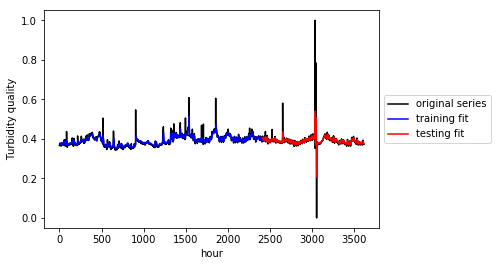

In [200]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot original series
plt.plot(dataset,color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt, split_pt + len(test_predict),1), test_predict, color = 'r')

# pretty up graph
plt.xlabel('hour')
plt.ylabel('Turbidity quality')
plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


# # plot original series
# plt.plot(dataset[12000:12020],color = 'k')

# # plot training set prediction
# # split_pt = train_test_split + window_size
# # plt.plot(np.arange(9, 109,1), train_predict[9000:9100],color = 'b')

# # plot testing set prediction
# plt.plot(np.arange(9,29,1), test_predict[672:692],color = 'r')

# # pretty up graph
# plt.xlabel('20 minutes')
# plt.ylabel('Water Level')
# plt.legend(['original series','training fit','testing fit'],loc='center left', bbox_to_anchor=(1, 0.5))
# plt.show()

# Implementation for Django